In [1]:
!nvidia-smi

Tue Mar 09 17:49:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:02:00.0  On |                  N/A |
|  0%   41C    P8     7W / 120W |    334MiB /  6144MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

# Pre-Processing and Training the Model
This notebook goes through the steps in turning the cleaned data into a representation that can be used to train a pre-trained BERT model for sentiment analysis.

__Columns__
- `target` sentiment of tweet (0=positive, 1=negative)
- `tweet` cleaned tweet text

_Note:_
_This notebook expects the zipped datasets to be in the ./resources sub-directory with the names train_twitter_data.zip, test_twitter_data, and validate_twitter_data (e.g., ./resources/train_twitter_data.zip). If the datasets do not exist open and run the `cleaning.ipynb` notebook to generate them._

In [2]:
import sys 
!{sys.executable} -m pip install tf-nightly --user --use-feature=2020-resolver
!{sys.executable} -m pip install tensorflow-text-nightly --user --use-feature=2020-resolver
!{sys.executable} -m pip install tf-models-nightly --user --use-feature=2020-resolver
!{sys.executable} -m pip install pydot

In [3]:
import os
import shutil

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

C:\Developer\lib\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210309). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


## Read Files
Read the files into memory and convert them to TensorFlow datasets to begin pre-processing.

In [4]:
RESOURCES_PATH = './resources/{}'

def twitter_data_to_dataset(filename):
    pd_df = pd.read_csv(RESOURCES_PATH.format(filename), encoding = 'ISO-8859-1', compression='zip')
    tweets =  tf.constant(pd_df['tweet'].to_numpy(dtype='U'), dtype=tf.string)
    targets = tf.constant(pd_df['target'].to_numpy(dtype='i4'), dtype=tf.int32)
    raw_ds = tf.data.Dataset.from_tensor_slices((tweets, targets))
    return raw_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = twitter_data_to_dataset('train_twitter_data.zip')
test_ds = twitter_data_to_dataset('test_twitter_data.zip')
validate_ds = twitter_data_to_dataset('validate_twitter_data.zip')

In [5]:
for feat, targ in train_ds.take(5):
    print ('Features: {}'.format(feat))
    print ('Target: {}'.format(targ))

Features: b'how long you been on here is not too shabby youll get more'
Target: 1
Features: b'i have drunk hickups i had a pretty laid back great night but i still can not help but be mad about the situation i put myself in'
Target: 1
Features: b'yeahshe passed last week so sad'
Target: 1
Features: b'although the guy playing the dmeo is playing it alot better'
Target: 1
Features: b'no I am even more frustrated'
Target: 1


## Load BERT Resources

In [6]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Pre-Processor

In [7]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [8]:
text_test = ['this is a positive tweet']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2023  2003  1037  3893  1056 28394  2102   102     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### Model

In [9]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [10]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9848738   0.18226533  0.12632792  0.12618974 -0.66139036  0.37884745
  0.9975925  -0.8945448  -0.13365187 -0.85632026 -0.3858759  -0.9872725 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.30224884  0.6054344   0.68965876 ... -0.3244271   0.308645
  -0.38157392]
 [-0.12072216  0.4816018   0.03000629 ...  0.45417544 -0.31766403
   0.63475037]
 [-0.698974    0.571599   -0.8237104  ... -0.04340702 -0.47640467
   0.12343752]
 ...
 [ 0.46994585  0.5490437  -0.10087968 ...  0.05938621  0.28654572
   0.12875855]
 [ 0.4503339   0.5586143   0.13378876 ... -0.01725397  0.6368232
   0.10774583]
 [-0.0938862  -0.12767975 -0.1426634  ... -0.24271569  1.1966645
  -0.4299879 ]]


## Define Model
A fine-tuned model for tweet sentiment analysis will be constructed using the input layer, a pre-processing model, the uncased BERT model, one Dense layer, and a Dropout layer.


In [11]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [12]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.3010928]], shape=(1, 1), dtype=float32)


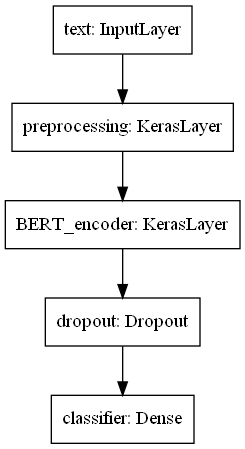

In [13]:
tf.keras.utils.plot_model(classifier_model)